# MLP
MLP, K=5, droput, 150 epoch.

lncRNA. Exclude the middle.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-08 21:04:34.875914


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_245'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-08 21:05:13.581661
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-08 21:05:13.988795
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4371
Num RCI: 4371
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4371 sequences.

Training # 1 1
2023-04-08 21:05:24.187150
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-08 21:05:24.411053
Discriminator ZERO -1
Train 1:0 939:1175 44.42%
Valid 1:0 228:311 42.30%
FIT
2023-04-08 21:05:24.490961


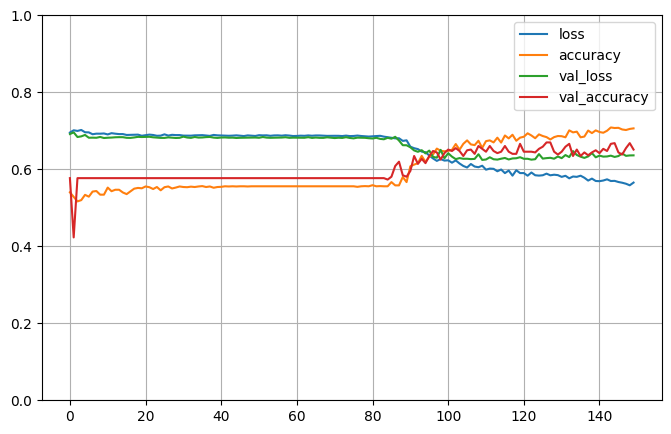


Testing # 1 1
2023-04-08 21:06:24.710006
2023-04-08 21:06:24.710462
PREDICT
2023-04-08 21:06:24.716824
Test 1:0 228:311 42.30%
Predict 1:0 210:329 38.96%
Test sizes (539, 1025) (539,)
Distrib of scores: 0.42054933 mean 0.22946118 std
Range of scores: 0.010826315 to 0.89446497
Score threshold 0.5
Confusion matrix
 [[226  85]
 [103 125]]
Normalized matrix
 [[0.41929499 0.15769944]
 [0.19109462 0.23191095]]
Extreme scores correct, pos:neg 72 169
Extreme scores incorrect pos:neg 39 53


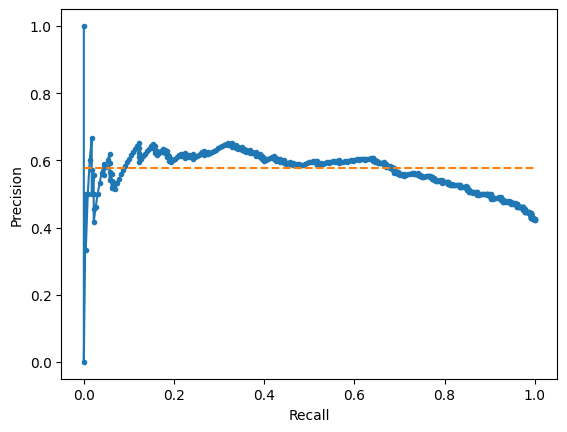

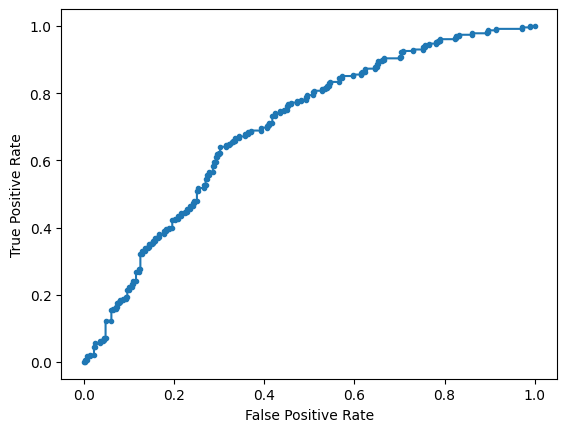

Accuracy: 65.12% Precision: 59.52% Recall: 54.82%
F1: 57.08% MCC: 0.2785
AUPRC: 57.21% AUROC: 69.77%
 accuracy [65.12059369202227]
 precision [59.523809523809526]
 recall [54.824561403508774]
 F1 [57.077625570776256]
 MCC [0.27852746416201635]
 AUPRC [57.21306388531079]
 AUROC [69.77280419698765]

Training # 1 2
2023-04-08 21:06:25.396550
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-08 21:06:25.618627
Discriminator ZERO -1
Train 1:0 926:1181 43.95%
Valid 1:0 241:305 44.14%
FIT
2023-04-08 21:06:25.697236


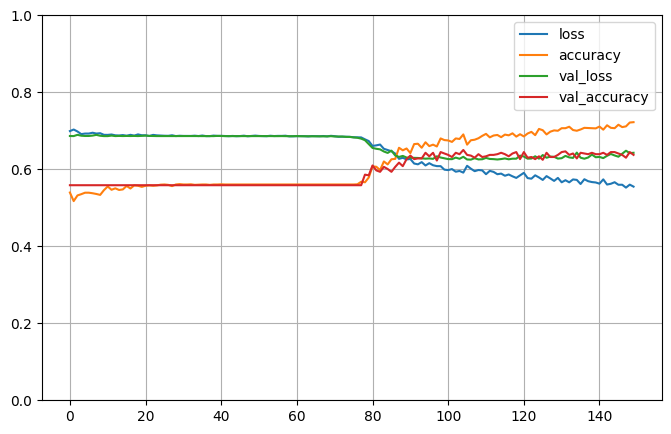


Testing # 1 2
2023-04-08 21:07:28.406620
2023-04-08 21:07:28.406661
PREDICT
2023-04-08 21:07:28.411866
Test 1:0 241:305 44.14%
Predict 1:0 191:355 34.98%
Test sizes (546, 1025) (546,)
Distrib of scores: 0.4021143 mean 0.22697356 std
Range of scores: 0.008563765 to 0.9048542
Score threshold 0.5
Confusion matrix
 [[231  74]
 [124 117]]
Normalized matrix
 [[0.42307692 0.13553114]
 [0.22710623 0.21428571]]
Extreme scores correct, pos:neg 59 175
Extreme scores incorrect pos:neg 38 64


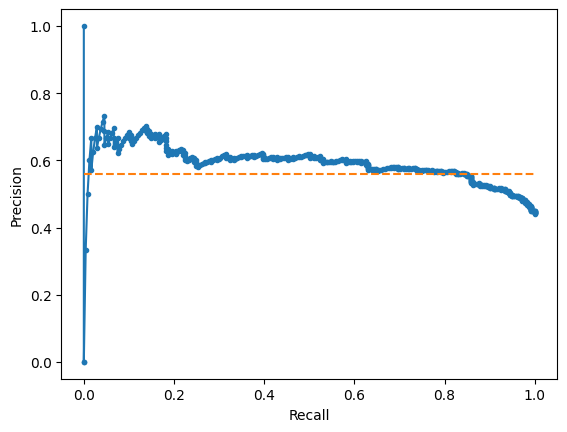

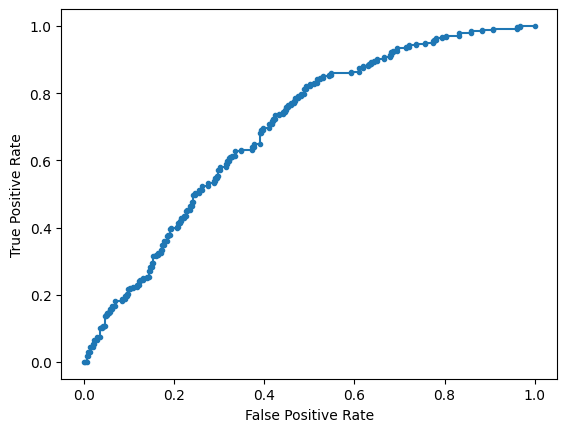

Accuracy: 63.74% Precision: 61.26% Recall: 48.55%
F1: 54.17% MCC: 0.2529
AUPRC: 59.11% AUROC: 69.49%
 accuracy [63.73626373626373]
 precision [61.25654450261781]
 recall [48.54771784232365]
 F1 [54.166666666666664]
 MCC [0.2528559915271235]
 AUPRC [59.10878138462701]
 AUROC [69.48778994626215]

Training # 1 3
2023-04-08 21:07:29.252533
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-08 21:07:29.451339
Discriminator ZERO -1
Train 1:0 951:1183 44.56%
Valid 1:0 216:303 41.62%
FIT
2023-04-08 21:07:29.538320


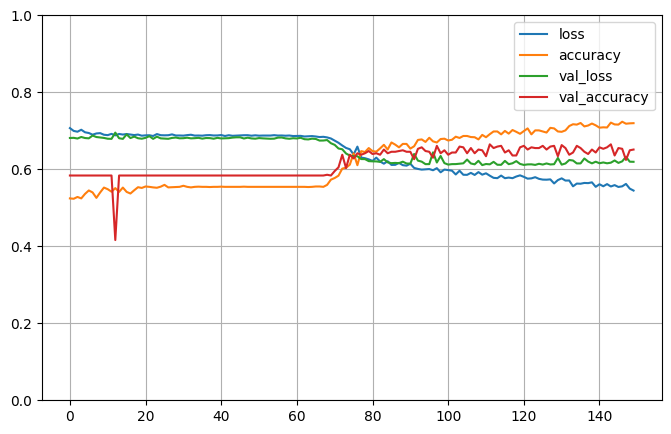


Testing # 1 3
2023-04-08 21:08:28.479973
2023-04-08 21:08:28.480039
PREDICT
2023-04-08 21:08:28.490596
Test 1:0 216:303 41.62%
Predict 1:0 225:294 43.35%
Test sizes (519, 1025) (519,)
Distrib of scores: 0.44590127 mean 0.2246587 std
Range of scores: 0.00910382 to 0.87409467
Score threshold 0.5
Confusion matrix
 [[208  95]
 [ 86 130]]
Normalized matrix
 [[0.40077071 0.18304432]
 [0.16570328 0.2504817 ]]
Extreme scores correct, pos:neg 77 154
Extreme scores incorrect pos:neg 43 43


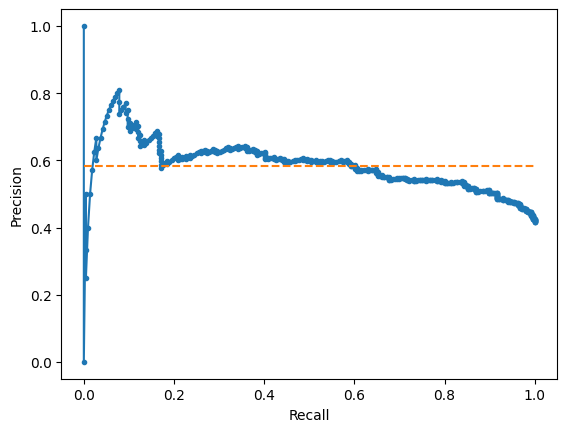

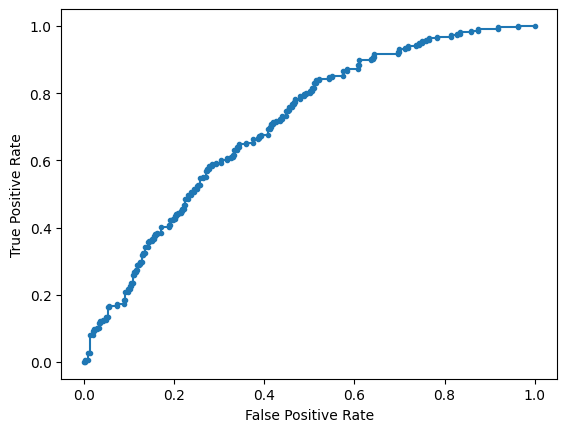

Accuracy: 65.13% Precision: 57.78% Recall: 60.19%
F1: 58.96% MCC: 0.2868
AUPRC: 58.54% AUROC: 70.57%
 accuracy [65.1252408477842]
 precision [57.77777777777777]
 recall [60.18518518518518]
 F1 [58.95691609977324]
 MCC [0.2867865543427595]
 AUPRC [58.540807293955545]
 AUROC [70.57052927514974]

Training # 1 4
2023-04-08 21:08:29.062991
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-08 21:08:29.284941
Discriminator ZERO -1
Train 1:0 936:1202 43.78%
Valid 1:0 231:284 44.85%
FIT
2023-04-08 21:08:29.368855


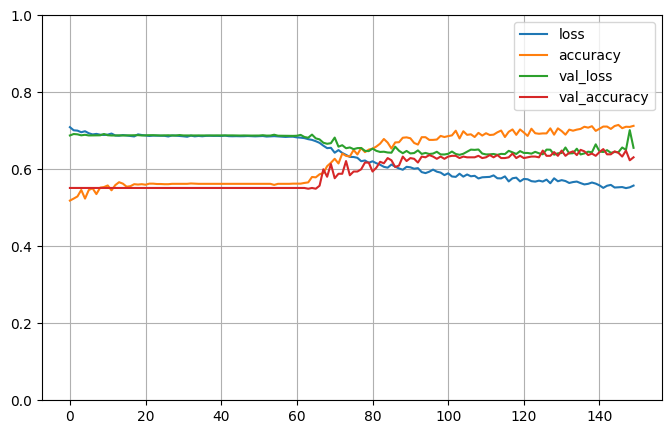


Testing # 1 4
2023-04-08 21:09:28.739109
2023-04-08 21:09:28.739163
PREDICT
2023-04-08 21:09:28.746173
Test 1:0 231:284 44.85%
Predict 1:0 181:334 35.15%
Test sizes (515, 1025) (515,)
Distrib of scores: 0.39958358 mean 0.22628553 std
Range of scores: 0.0070823715 to 0.86556804
Score threshold 0.5
Confusion matrix
 [[214  70]
 [120 111]]
Normalized matrix
 [[0.41553398 0.13592233]
 [0.23300971 0.21553398]]
Extreme scores correct, pos:neg 63 164
Extreme scores incorrect pos:neg 31 67


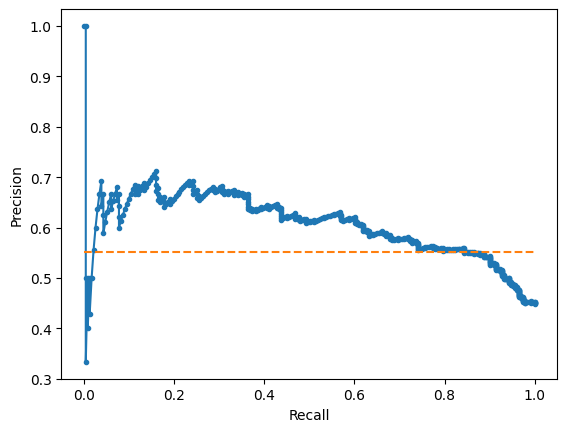

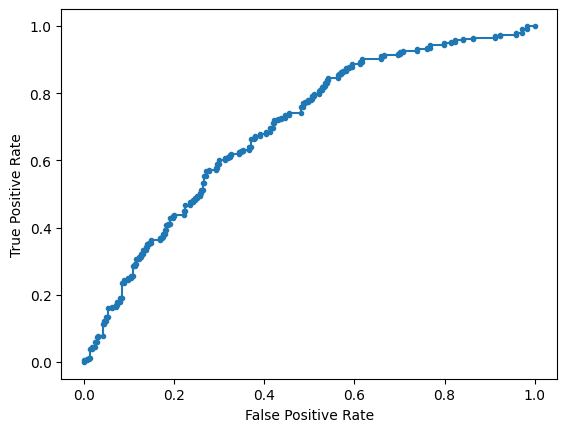

Accuracy: 63.11% Precision: 61.33% Recall: 48.05%
F1: 53.88% MCC: 0.2438
AUPRC: 60.67% AUROC: 69.52%
 accuracy [63.10679611650486]
 precision [61.32596685082873]
 recall [48.05194805194805]
 F1 [53.883495145631066]
 MCC [0.24380570032031834]
 AUPRC [60.666733720258925]
 AUROC [69.5186269129931]

Training # 1 5
2023-04-08 21:09:29.362678
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-08 21:09:29.611338
Discriminator ZERO -1
Train 1:0 916:1203 43.23%
Valid 1:0 251:283 47.00%
FIT
2023-04-08 21:09:29.732940


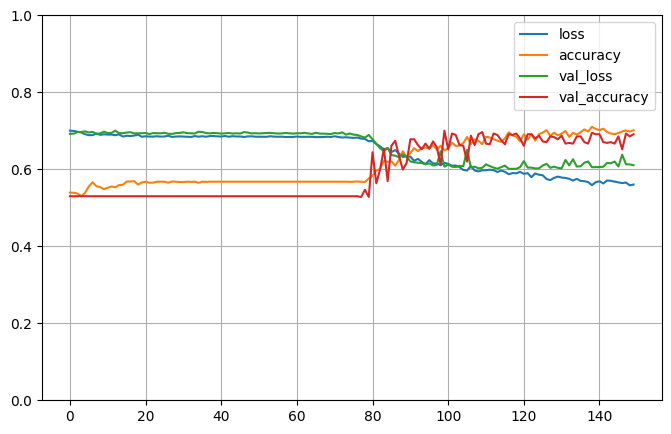


Testing # 1 5
2023-04-08 21:10:53.662197
2023-04-08 21:10:53.662612
PREDICT
2023-04-08 21:10:53.667780
Test 1:0 251:283 47.00%
Predict 1:0 242:292 45.32%
Test sizes (534, 1025) (534,)
Distrib of scores: 0.44792324 mean 0.21978419 std
Range of scores: 0.013850928 to 0.8685649
Score threshold 0.5
Confusion matrix
 [[205  78]
 [ 87 164]]
Normalized matrix
 [[0.38389513 0.14606742]
 [0.16292135 0.3071161 ]]
Extreme scores correct, pos:neg 89 137
Extreme scores incorrect pos:neg 31 49


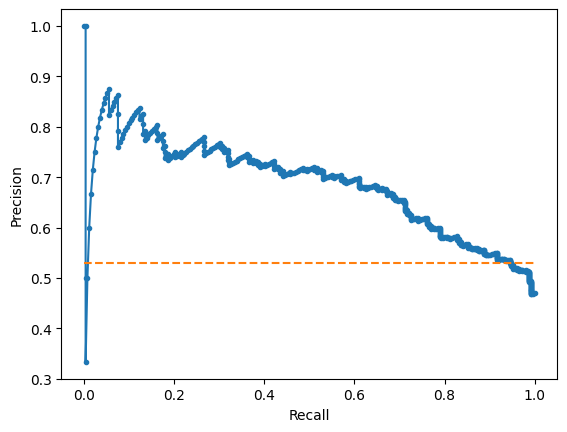

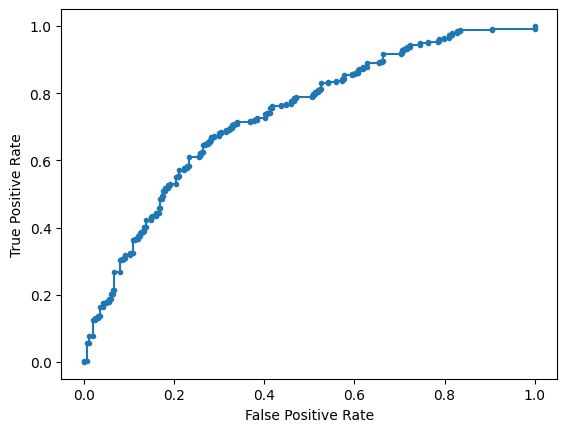

Accuracy: 69.10% Precision: 67.77% Recall: 65.34%
F1: 66.53% MCC: 0.3788
AUPRC: 68.59% AUROC: 73.50%
 accuracy [69.10112359550563]
 precision [67.76859504132231]
 recall [65.33864541832669]
 F1 [66.5314401622718]
 MCC [0.3787531279989429]
 AUPRC [68.59169057152762]
 AUROC [73.49964101192403]

Training # 2 1
2023-04-08 21:10:54.566908
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-08 21:10:54.781513
Discriminator ZERO -1
Train 1:0 941:1187 44.22%
Valid 1:0 226:299 43.05%
FIT
2023-04-08 21:10:54.897071


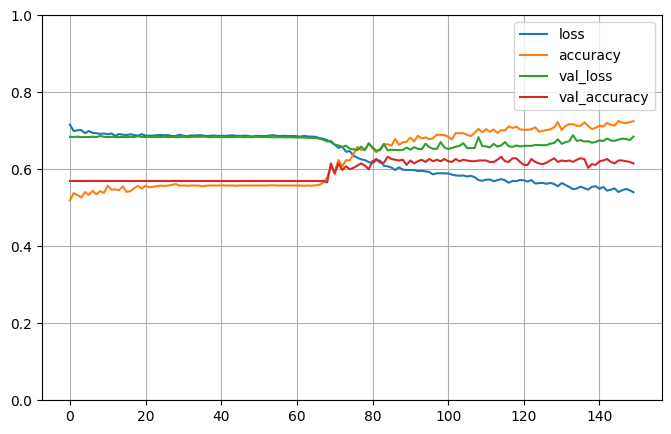


Testing # 2 1
2023-04-08 21:12:18.556715
2023-04-08 21:12:18.556770
PREDICT
2023-04-08 21:12:18.562232
Test 1:0 226:299 43.05%
Predict 1:0 190:335 36.19%
Test sizes (525, 1025) (525,)
Distrib of scores: 0.3975305 mean 0.23283744 std
Range of scores: 0.0028421597 to 0.89597875
Score threshold 0.5
Confusion matrix
 [[216  83]
 [119 107]]
Normalized matrix
 [[0.41142857 0.15809524]
 [0.22666667 0.20380952]]
Extreme scores correct, pos:neg 56 168
Extreme scores incorrect pos:neg 38 72


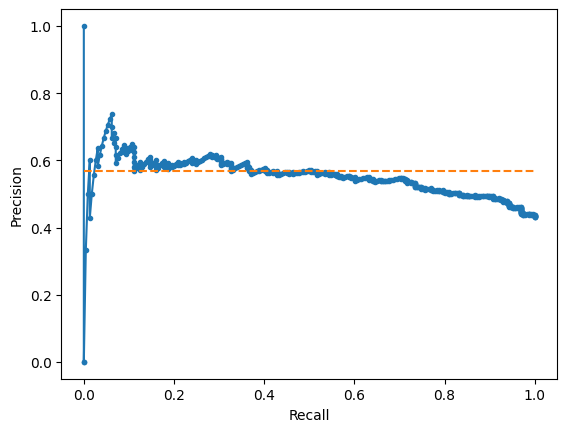

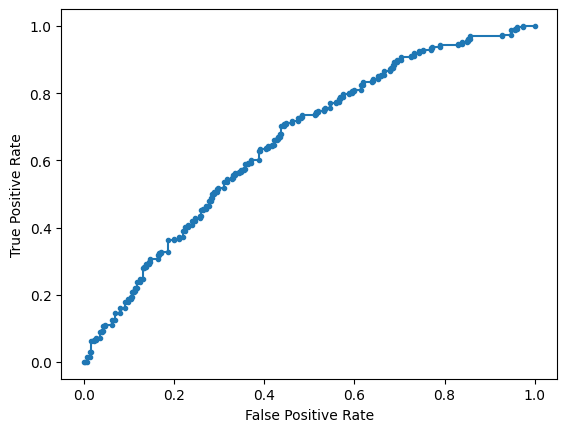

Accuracy: 61.52% Precision: 56.32% Recall: 47.35%
F1: 51.44% MCC: 0.2018
AUPRC: 55.17% AUROC: 65.68%
 accuracy [61.523809523809526]
 precision [56.315789473684205]
 recall [47.34513274336283]
 F1 [51.4423076923077]
 MCC [0.20180639663661062]
 AUPRC [55.166075934427504]
 AUROC [65.6820670672152]

Training # 2 2
2023-04-08 21:12:19.224721
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-08 21:12:19.426682
Discriminator ZERO -1
Train 1:0 929:1189 43.86%
Valid 1:0 238:297 44.49%
FIT
2023-04-08 21:12:19.507113


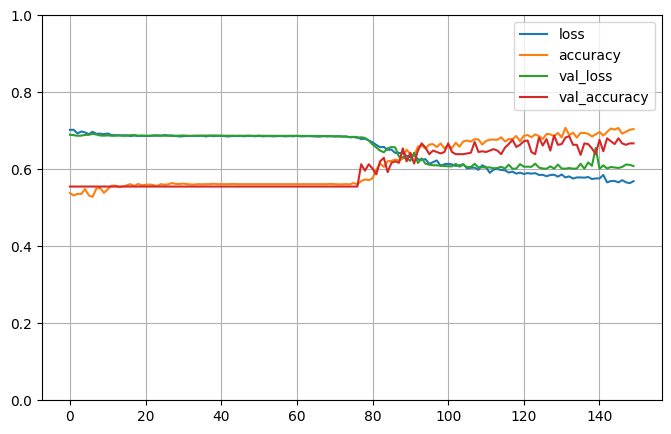


Testing # 2 2
2023-04-08 21:13:42.754272
2023-04-08 21:13:42.754339
PREDICT
2023-04-08 21:13:42.764101
Test 1:0 238:297 44.49%
Predict 1:0 268:267 50.09%
Test sizes (535, 1025) (535,)
Distrib of scores: 0.48960966 mean 0.2274674 std
Range of scores: 0.018258585 to 0.90464896
Score threshold 0.5
Confusion matrix
 [[193 104]
 [ 74 164]]
Normalized matrix
 [[0.36074766 0.19439252]
 [0.13831776 0.30654206]]
Extreme scores correct, pos:neg 102 132
Extreme scores incorrect pos:neg 60 28


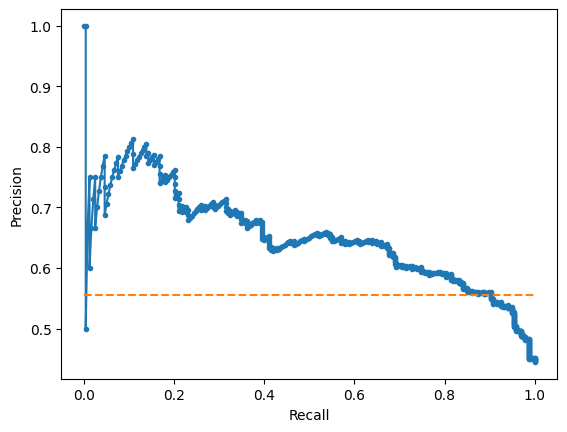

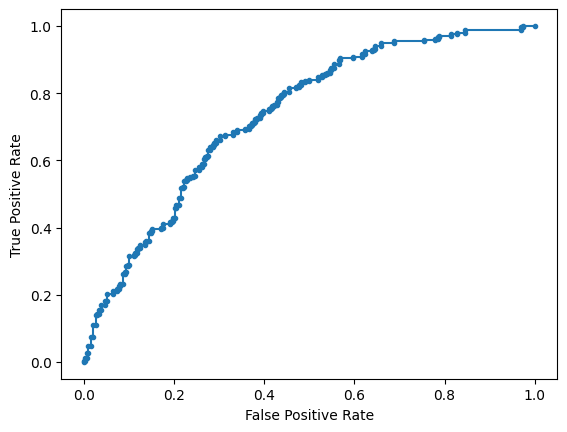

Accuracy: 66.73% Precision: 61.19% Recall: 68.91%
F1: 64.82% MCC: 0.3368
AUPRC: 65.07% AUROC: 73.38%
 accuracy [66.72897196261682]
 precision [61.19402985074627]
 recall [68.90756302521008]
 F1 [64.82213438735178]
 MCC [0.33684070955826906]
 AUPRC [65.07258959313283]
 AUROC [73.38086749851456]

Training # 2 3
2023-04-08 21:13:43.394656
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-08 21:13:43.613052
Discriminator ZERO -1
Train 1:0 924:1198 43.54%
Valid 1:0 243:288 45.76%
FIT
2023-04-08 21:13:43.699452


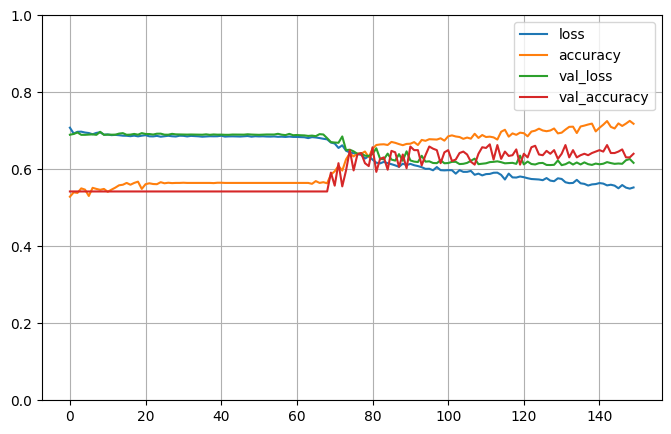


Testing # 2 3
2023-04-08 21:15:07.533097
2023-04-08 21:15:07.533148
PREDICT
2023-04-08 21:15:07.546709
Test 1:0 243:288 45.76%
Predict 1:0 234:297 44.07%
Test sizes (531, 1025) (531,)
Distrib of scores: 0.45289332 mean 0.22705589 std
Range of scores: 0.014555176 to 0.87841314
Score threshold 0.5
Confusion matrix
 [[197  91]
 [100 143]]
Normalized matrix
 [[0.37099812 0.17137476]
 [0.18832392 0.2693032 ]]
Extreme scores correct, pos:neg 80 139
Extreme scores incorrect pos:neg 46 39


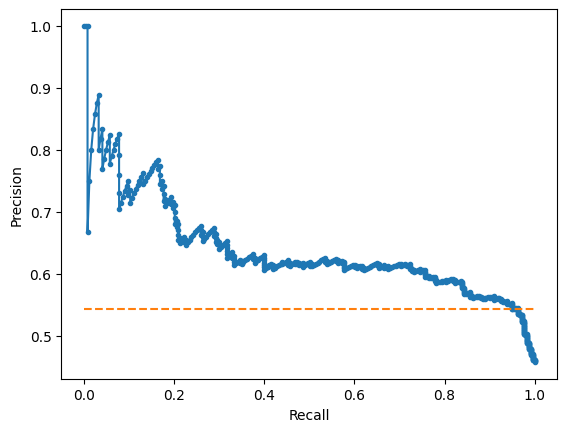

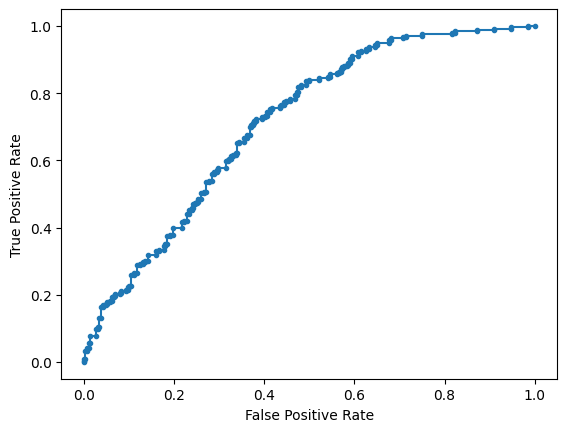

Accuracy: 64.03% Precision: 61.11% Recall: 58.85%
F1: 59.96% MCC: 0.2735
AUPRC: 63.93% AUROC: 71.24%
 accuracy [64.030131826742]
 precision [61.111111111111114]
 recall [58.8477366255144]
 F1 [59.95807127882598]
 MCC [0.2734562992600348]
 AUPRC [63.93179523523678]
 AUROC [71.237711476909]

Training # 2 4
2023-04-08 21:15:08.181369
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-08 21:15:08.444202
Discriminator ZERO -1
Train 1:0 953:1173 44.83%
Valid 1:0 214:313 40.61%
FIT
2023-04-08 21:15:08.527338


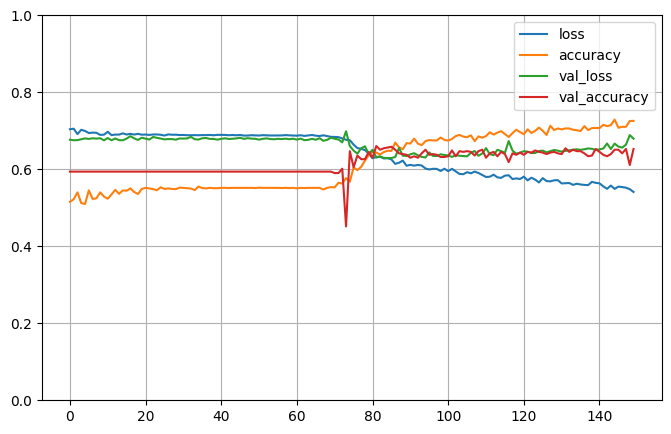


Testing # 2 4
2023-04-08 21:16:08.679442
2023-04-08 21:16:08.679492
PREDICT
2023-04-08 21:16:08.690248
Test 1:0 214:313 40.61%
Predict 1:0 163:364 30.93%
Test sizes (527, 1025) (527,)
Distrib of scores: 0.3649241 mean 0.2479608 std
Range of scores: 0.004782321 to 0.8995207
Score threshold 0.5
Confusion matrix
 [[247  66]
 [117  97]]
Normalized matrix
 [[0.4686907  0.12523719]
 [0.22201139 0.18406072]]
Extreme scores correct, pos:neg 54 197
Extreme scores incorrect pos:neg 41 77


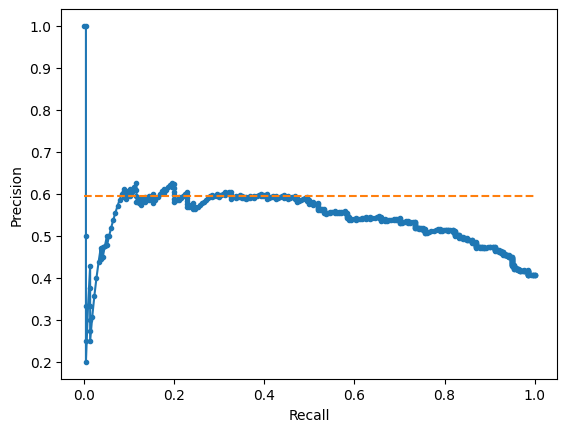

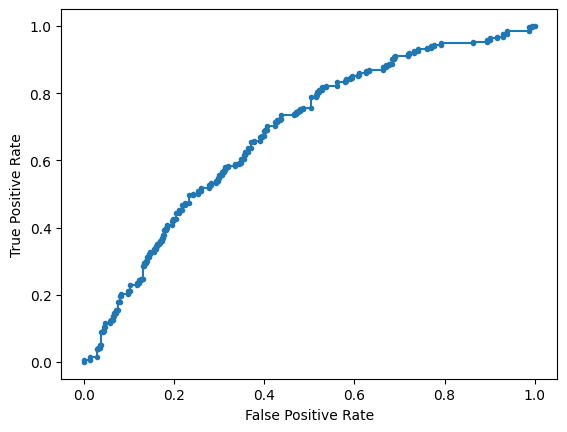

Accuracy: 65.28% Precision: 59.51% Recall: 45.33%
F1: 51.46% MCC: 0.2576
AUPRC: 54.23% AUROC: 68.10%
 accuracy [65.2751423149905]
 precision [59.50920245398773]
 recall [45.32710280373832]
 F1 [51.45888594164456]
 MCC [0.25756226831425477]
 AUPRC [54.22824318466428]
 AUROC [68.09889223970619]

Training # 2 5
2023-04-08 21:16:09.609483
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-08 21:16:09.828632
Discriminator ZERO -1
Train 1:0 921:1197 43.48%
Valid 1:0 246:289 45.98%
FIT
2023-04-08 21:16:09.967859


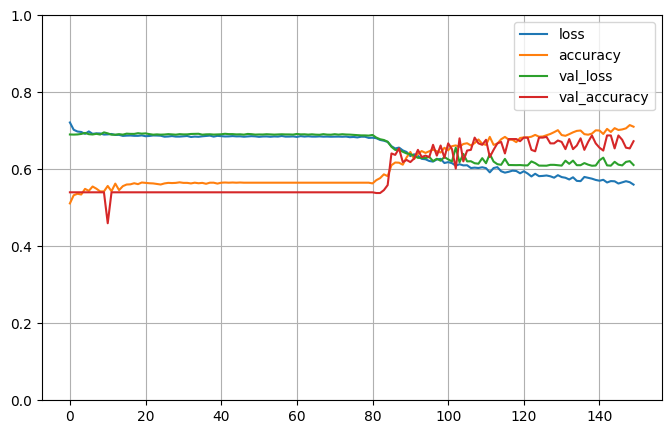


Testing # 2 5
2023-04-08 21:17:33.841251
2023-04-08 21:17:33.841689
PREDICT
2023-04-08 21:17:33.847543
Test 1:0 246:289 45.98%
Predict 1:0 241:294 45.05%
Test sizes (535, 1025) (535,)
Distrib of scores: 0.47393495 mean 0.21399412 std
Range of scores: 0.023278125 to 0.8968516
Score threshold 0.5
Confusion matrix
 [[204  85]
 [ 90 156]]
Normalized matrix
 [[0.38130841 0.1588785 ]
 [0.1682243  0.29158879]]
Extreme scores correct, pos:neg 90 132
Extreme scores incorrect pos:neg 38 31


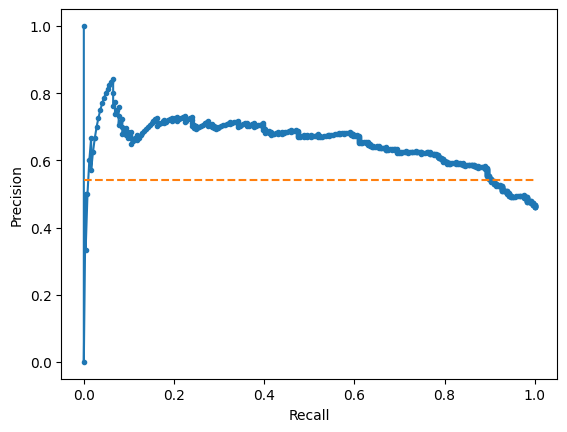

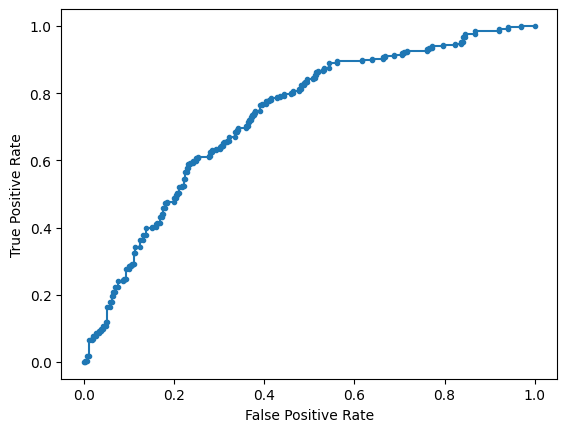

Accuracy: 67.29% Precision: 64.73% Recall: 63.41%
F1: 64.07% MCC: 0.3406
AUPRC: 65.14% AUROC: 72.94%
 accuracy [67.28971962616822]
 precision [64.73029045643153]
 recall [63.41463414634146]
 F1 [64.06570841889118]
 MCC [0.3406040881563771]
 AUPRC [65.13923472554681]
 AUROC [72.94005119981996]
2023-04-08 21:17:34.732888


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.10% std 2.19
 precision mean 61.05% std 3.28
 recall mean 56.08% std 8.45
 F1 mean 58.24% std 5.56
 MCC mean 0.2851 std 0.0529
 AUPRC mean 60.77% std 4.75
 AUROC mean 70.42% std 2.48
 accuracy [[65.12059369202227], [63.73626373626373], [65.1252408477842], [63.10679611650486], [69.10112359550563], [61.523809523809526], [66.72897196261682], [64.030131826742], [65.2751423149905], [67.28971962616822]]
 precision [[59.523809523809526], [61.25654450261781], [57.77777777777777], [61.32596685082873], [67.76859504132231], [56.315789473684205], [61.19402985074627], [61.111111111111114], [59.50920245398773], [64.73029045643153]]
 recall [[54.824561403508774], [48.54771784232365], [60.18518518518518], [48.05194805194805], [65.33864541832669], [47.34513274336283], [68.90756302521008], [58.8477366255144], [45.32710280373832], [63.41463414634146]]
 F1 [[57.077625570776256], [54.166666666666664], [58.95691609977324], [53.883495145631066], [66.5314401622718], [51.4423076923077], [64.8